# <span style="font-size:1.5em;"> Diagnosing Pediatric Pneumonia
X-ray image classifcation with Convolutional Neural Networks

Authors: Colin Pelzer, Tamiru Renka, Daniel Burdeno

---

# Contents
<l></l>

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>

- <a href="#Business Understanding">Business Understanding</a>  

- <a href="#Data Understanding">Data Understanding</a>  

- <a href="#Data Preparation">Data Preparation</a>  
    
- <a href="#Model Creation">Model Creation</a>
    
- <a href="#Visualizations">Visualizations</a>
    
- <a href="#Conclusion">Conclusion</a>

- <a href="#Next Steps">Next Steps</a>

---

# <a id="#Overview">Overview</a>

> This project utlizes chest X-ray images to train a convolutional neural network for the identifcation/classifaction of pediatric pneumonia. We attempt to build a model that can accurately predict whether there is pneumonia in the lungs or not. An iterative approach to model building was taken in order to produce the highest accuracy and recall scores.

# <a id="#Business Understanding">Business Understanding</a>

> According to the Wolrd Health Organization(WHO), pneumonia is the single largest infectious cause of death in children worldwide. 

# <a id="Data Understanding">Data Understanding</a>

# <a id="Data Preparation">Data Preparation</a>

## Load relevant packages

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, losses, metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
np.random.seed(42)

## Load Data

> 

In [4]:
# Set path to were dataset is saved (directory chest_xray) for train and test sets
train_path = 'chest_xray/train/' 
test_path = 'chest_xray/test/'

# Set a path within train dataset to both classes (NORMAL/PNEUMONIA)
train_n_path = train_path +'NORMAL/'
train_p_path = train_path +'PNEUMONIA/'

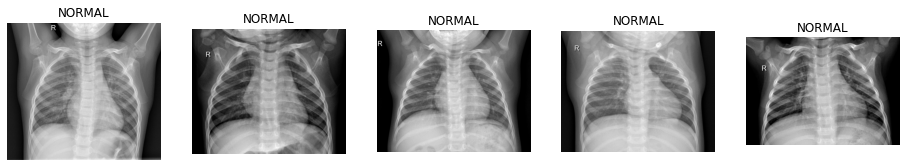

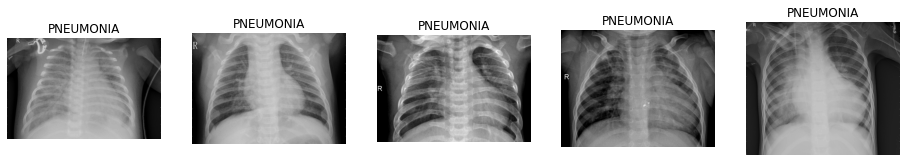

In [8]:
# View the first 5 images in train set for both normal and pneumonia
plt.figure(figsize=(16,16))
for n in range(5):
    normal_img = os.listdir(train_n_path)[n]
    normal_img_address = train_n_path+normal_img
    normal_load = Image.open(normal_img_address)
    ax = plt.subplot(5,5,n+1)
    plt.imshow(normal_load, cmap ='gray')
    plt.title("NORMAL")
    plt.axis("off")

plt.figure(figsize=(16,16))
for n in range(5):
    pneumonia_img =  os.listdir(train_p_path)[n]
    pneumonia_img_address = train_p_path+pneumonia_img
    pneumonia_load = Image.open(pneumonia_img_address)
    ax = plt.subplot(5,5,n+1)
    plt.imshow(pneumonia_load, cmap ='gray')
    plt.title("PNEUMONIA")
    plt.axis("off")

> In order to pass our image datasets through a neural network we need to preprocess the images into usable data. We rescale the data by dividing by 255 due to the images being x-ray (greyscale). We also resize each image to be 64 by 64 pixels so they are all the same size. Due to the unsuable nature of the validation set given, we utlize a validation split within ImageDataGenerator to produce a 80% - 20% split on our train set - validation set respectively. Class mode is binary as we are trying to predict normal vs. pneumonia images (binary classifcation).

In [10]:
# Utlize ImageDataGenerator from kera.preprocessing
img_dgen = ImageDataGenerator(rescale=1./255, validation_split = 0.20)

# Creation of train set, note the subset argument due to the validation split
train_set = img_dgen.flow_from_directory(train_path, target_size=(64, 64), 
                                         color_mode='grayscale', class_mode='binary', subset='training')

# Creation of validation set from 20% of the train data
validation_set = img_dgen.flow_from_directory(train_path, target_size=(64, 64), 
                                         color_mode='grayscale', class_mode='binary', subset='validation')

# Creation of test set from the test path, shuffle set to false for use in future model predictions
test_set = img_dgen.flow_from_directory(test_path, target_size=(64, 64), 
                                         color_mode='grayscale', class_mode='binary', shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


> We also created a seperate set of data for use in the creation of a dummy model. This was necessary because sklearn DummyClassifer cannot utilize the same dataset file structure that Tensorflow can. 

In [12]:
# Batch size set to the number of images found above in order to not batch data for the dummy model. Validation set not needed for dummy model
train_set_dummy = img_dgen.flow_from_directory(train_path,
                                               target_size=(64, 64),
                                               color_mode='grayscale', 
                                               class_mode='binary', 
                                               subset='training', 
                                               batch_size=4173)

test_set_dummy = img_dgen.flow_from_directory(test_path, 
                                              target_size=(64, 64),
                                              color_mode='grayscale',
                                              class_mode='binary',
                                              shuffle=False,
                                              batch_size=624)

# Split train and test dummy sets into images and corresponding labels for dummy model training
train_images, train_labels = next(train_set_dummy)
test_images, test_labels = next(test_set_dummy)

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Dataset Augmentation

> Our first models were created using the initial generated datasets, after training of these models we then realized we would need to perform data augmentation in order to produce quality results. We conduct a variety of augmentations utlizing the ImageDataGenerator. Augmentation was only performed on the train_set, again withholding 20% from the validation set. This augmented data set was then used to train subsequent models and in our final model.

In [13]:
train_datagen_aug = ImageDataGenerator(rescale=1./255,
                                   validation_split = 0.20,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

train_set_aug = train_datagen_aug.flow_from_directory(train_path, target_size=(64, 64), 
                                         color_mode='grayscale', class_mode='binary', subset='training')

Found 4173 images belonging to 2 classes.


# <a id="Model Creation">Model Creation</a> 

> Performance of our models was measured using both accuracy score and recall score. Recall score is important in order to minimize the number of false negative results. We want to avoid classifing an image with pneumonia as being normal as much as possible. 

## Baseline (dummy) Model

In [15]:
# sklearn dummy classifer that will always return the most frequent class (pneumonia)
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

In [21]:
# Scoring dummy model for accuracy and recall
print(baseline_model.score(test_images, test_labels))

# Generate predicts using model
y_pred_base = baseline_model.predict(test_images)

# Recall score
recall_score(test_labels, y_pred_base)

0.625


1.0

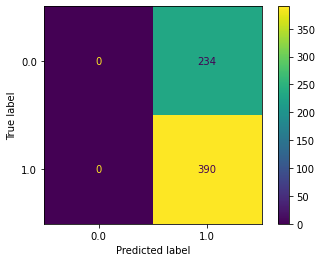

In [23]:
# Visualize confusion matrix for dummy model
plot_confusion_matrix(baseline_model, test_images, test_labels)

> Given that our baseline model will always predict the positive class (most frequent) the recall score of 1 is misleading as we do not have any false negatives. The low accuracy score is reflective of the high amount of false positives. While we do care more about false negatives than false postives, we want to also increase accuracy as much as possible by reducing misclassfied images.

## Simple Neural Network

In [28]:
# Creation of neural network model
simple_model = models.Sequential([
    layers.Flatten(input_shape=(64, 64, 1)),
    layers.Dense(20, activation='relu'),
    layers.Dense(7, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simple_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])

simple_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                81940     
_________________________________________________________________
dense_13 (Dense)             (None, 7)                 147       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 6         
Total params: 82,133
Trainable params: 82,133
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Fit the train_set data to the simple model built above and use validation set 
simple_history = simple_model.fit(train_set,
                    epochs=30,
                    batch_size=32,
                    validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 31s 235ms/step - loss: 0.4014 - accuracy: 0.8291 - recall: 0.9529 - auc: 0.8527 - prc: 0.9338 - val_loss: 0.2692 - val_accuracy: 0.8965 - val_recall: 0.9394 - val_auc: 0.9447 - val_prc: 0.9798
Epoch 2/30
131/131 [==============================] - 31s 236ms/step - loss: 0.1942 - accuracy: 0.9319 - recall: 0.9652 - auc: 0.9682 - prc: 0.9865 - val_loss: 0.2099 - val_accuracy: 0.9080 - val_recall: 0.9097 - val_auc: 0.9743 - val_prc: 0.9913
Epoch 3/30
131/131 [==============================] - 31s 237ms/step - loss: 0.1659 - accuracy: 0.9379 - recall: 0.9639 - auc: 0.9771 - prc: 0.9914 - val_loss: 0.1742 - val_accuracy: 0.9291 - val_recall: 0.9381 - val_auc: 0.9805 - val_prc: 0.9935
Epoch 4/30
131/131 [==============================] - 30s 232ms/step - loss: 0.1371 - accuracy: 0.9485 - recall: 0.9684 - auc: 0.9847 - prc: 0.9945 - val_loss: 0.1839 - val_accuracy: 0.9204 - val_recall: 0.9161 - val_auc: 0.9820 - val_prc: 0.9941
Epoch 5/30
1

In [30]:
# Evaluate our simple model on the test set
simple_model.evaluate(test_set)

20/20 [==============================] - 3s 140ms/step - loss: 1.2548 - accuracy: 0.7228 - recall: 0.9923 - auc: 0.8295 - prc: 0.8375


[1.2547757625579834,
 0.7227563858032227,
 0.9923076629638672,
 0.8295036554336548,
 0.8375241756439209]

In [42]:
def conf_mat(model):
    y_pred = model.predict(test_set)
    y_pred = (y_pred>0.5).astype(np.int)
    display(ConfusionMatrixDisplay(confusion_matrix(test_set.classes, y_pred), display_labels=['Normal', 'Pneumonia']).plot())

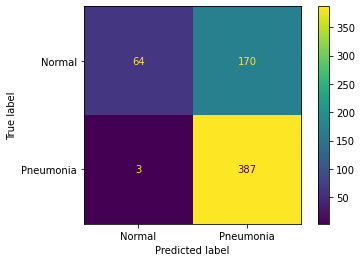

In [36]:
# Visualize confusion matrix for simple model
y_pred = simple_model.predict(test_set)
y_pred = (y_pred>0.5).astype(np.int)
display(ConfusionMatrixDisplay(confusion_matrix(test_set.classes, y_pred), display_labels=['Normal', 'Pneumonia']).plot())

> For our first iteration of neural network model we only used Dense network layers to see if we could improve from the dummy model. Our final activation layer will be sigmoid for all future models as we are predicting a binary classification. We will also use binary crossentropy as our loss funcation because of this. The Adam optimizer was chosen as it is well known to perform the best for image classifcation. The input shape matches the image resizng we did in the data generation step. While the simple performed well on the train data, as well as the validation data, it did not on the test data and we still have a high amount of false predictions. Our model is heavily overfit as we would expect from a simple dense network. We will attempt to add in convolutional layers in order to improve the model and reduce overfitting.

## Convolutional Neural Network Models

In [37]:
# We decided to add in two Conv2d layers at different levels, as well as a max pooling layer after each. 
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])

cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                802880    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [38]:
cnn_history = cnn_model.fit(train_set,
                    epochs=30,
                    batch_size=32,
                    validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 35s 267ms/step - loss: 0.2920 - accuracy: 0.8747 - auc: 0.9267 - prc: 0.9724 - val_loss: 0.1311 - val_accuracy: 0.9521 - val_auc: 0.9898 - val_prc: 0.9965
Epoch 2/30
131/131 [==============================] - 34s 260ms/step - loss: 0.1219 - accuracy: 0.9518 - auc: 0.9879 - prc: 0.9957 - val_loss: 0.0963 - val_accuracy: 0.9693 - val_auc: 0.9939 - val_prc: 0.9980
Epoch 3/30
131/131 [==============================] - 34s 262ms/step - loss: 0.0887 - accuracy: 0.9674 - auc: 0.9936 - prc: 0.9978 - val_loss: 0.0894 - val_accuracy: 0.9712 - val_auc: 0.9946 - val_prc: 0.9982
Epoch 4/30
131/131 [==============================] - 34s 257ms/step - loss: 0.0879 - accuracy: 0.9698 - auc: 0.9933 - prc: 0.9975 - val_loss: 0.1772 - val_accuracy: 0.9367 - val_auc: 0.9940 - val_prc: 0.9980
Epoch 5/30
131/131 [==============================] - 34s 262ms/step - loss: 0.0795 - accuracy: 0.9696 - auc: 0.9941 - prc: 0.9975 - val_loss: 0.1020 - val_accuracy

In [40]:
cnn_model.evaluate(test_set)

20/20 [==============================] - 3s 137ms/step - loss: 2.9772 - accuracy: 0.7676 - auc: 0.7543 - prc: 0.7737


[2.9771745204925537,
 0.7676281929016113,
 0.7542845010757446,
 0.7737281322479248]

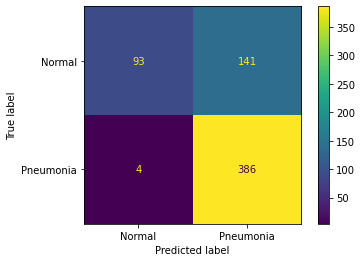

In [43]:
conf_mat(cnn_model)

> 

In [45]:
cnn2_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

cnn2_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])

cnn2_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

In [46]:
cnn2_history = cnn2_model.fit(train_set,
                    epochs=30,
                    batch_size=32,
                    validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 34s 257ms/step - loss: 0.3085 - accuracy: 0.8660 - recall: 0.9552 - auc: 0.9195 - prc: 0.9686 - val_loss: 0.2332 - val_accuracy: 0.8993 - val_recall: 0.9948 - val_auc: 0.9853 - val_prc: 0.9935
Epoch 2/30
131/131 [==============================] - 33s 256ms/step - loss: 0.1338 - accuracy: 0.9514 - recall: 0.9690 - auc: 0.9853 - prc: 0.9943 - val_loss: 0.0982 - val_accuracy: 0.9616 - val_recall: 0.9665 - val_auc: 0.9930 - val_prc: 0.9977
Epoch 3/30
131/131 [==============================] - 33s 254ms/step - loss: 0.1160 - accuracy: 0.9559 - recall: 0.9710 - auc: 0.9891 - prc: 0.9961 - val_loss: 0.1022 - val_accuracy: 0.9616 - val_recall: 0.9742 - val_auc: 0.9917 - val_prc: 0.9973
Epoch 4/30
131/131 [==============================] - 34s 256ms/step - loss: 0.0908 - accuracy: 0.9676 - recall: 0.9787 - auc: 0.9926 - prc: 0.9971 - val_loss: 0.0945 - val_accuracy: 0.9636 - val_recall: 0.9626 - val_auc: 0.9937 - val_prc: 0.9980
Epoch 5/30
1

In [48]:
cnn2_model.evaluate(test_set)

20/20 [==============================] - 3s 138ms/step - loss: 2.5176 - accuracy: 0.7596 - recall: 0.9923 - auc: 0.7683 - prc: 0.7838


[2.5175819396972656,
 0.7596153616905212,
 0.9923076629638672,
 0.7683432102203369,
 0.7838069796562195]

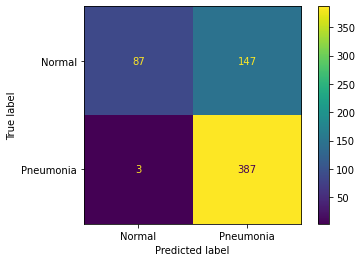

In [49]:
conf_mat(cnn2_model)

> 

In [50]:
cnn3_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

cnn3_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])

cnn3_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)         

In [51]:
cnn3_history = cnn3_model.fit(train_set,
                    epochs=30,
                    batch_size=32,
                    validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 33s 249ms/step - loss: 0.4229 - accuracy: 0.7831 - recall: 0.9800 - auc: 0.8395 - prc: 0.9360 - val_loss: 0.2562 - val_accuracy: 0.9003 - val_recall: 0.9290 - val_auc: 0.9610 - val_prc: 0.9860
Epoch 2/30
131/131 [==============================] - 32s 242ms/step - loss: 0.1991 - accuracy: 0.9236 - recall: 0.9548 - auc: 0.9681 - prc: 0.9874 - val_loss: 0.1317 - val_accuracy: 0.9540 - val_recall: 0.9652 - val_auc: 0.9876 - val_prc: 0.9958
Epoch 3/30
131/131 [==============================] - 32s 243ms/step - loss: 0.1659 - accuracy: 0.9367 - recall: 0.9639 - auc: 0.9774 - prc: 0.9911 - val_loss: 0.1546 - val_accuracy: 0.9348 - val_recall: 0.9226 - val_auc: 0.9892 - val_prc: 0.9964
Epoch 4/30
131/131 [==============================] - 33s 253ms/step - loss: 0.1290 - accuracy: 0.9528 - recall: 0.9674 - auc: 0.9864 - prc: 0.9950 - val_loss: 0.1027 - val_accuracy: 0.9645 - val_recall: 0.9626 - val_auc: 0.9938 - val_prc: 0.9980
Epoch 5/30
1

In [52]:
cnn3_model.evaluate(test_set)

20/20 [==============================] - 3s 135ms/step - loss: 2.1073 - accuracy: 0.7212 - recall: 1.0000 - auc: 0.7593 - prc: 0.7771


[2.107253074645996,
 0.7211538553237915,
 1.0,
 0.7592756748199463,
 0.7771286368370056]

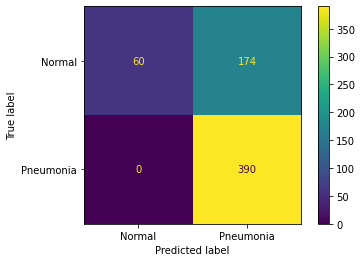

In [53]:
conf_mat(cnn3_model)

>

In [54]:
cnn4_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

cnn4_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])

cnn4_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)       

In [55]:
cnn4_history = cnn4_model.fit(train_set_aug,
                    epochs=30,
                    batch_size=32,
                    validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 35s 271ms/step - loss: 0.5585 - accuracy: 0.7323 - recall: 0.9639 - auc: 0.6098 - prc: 0.8177 - val_loss: 0.5696 - val_accuracy: 0.7181 - val_recall: 0.9148 - val_auc: 0.6443 - val_prc: 0.8610
Epoch 2/30
131/131 [==============================] - 34s 260ms/step - loss: 0.4774 - accuracy: 0.7431 - recall: 0.9345 - auc: 0.7687 - prc: 0.9041 - val_loss: 0.5426 - val_accuracy: 0.7478 - val_recall: 0.9755 - val_auc: 0.7188 - val_prc: 0.9016
Epoch 3/30
131/131 [==============================] - 35s 266ms/step - loss: 0.4504 - accuracy: 0.7534 - recall: 0.9235 - auc: 0.7963 - prc: 0.9236 - val_loss: 0.4907 - val_accuracy: 0.7622 - val_recall: 0.8813 - val_auc: 0.7743 - val_prc: 0.9187
Epoch 4/30
131/131 [==============================] - 35s 270ms/step - loss: 0.4262 - accuracy: 0.7678 - recall: 0.9190 - auc: 0.8270 - prc: 0.9346 - val_loss: 0.4704 - val_accuracy: 0.7622 - val_recall: 0.7561 - val_auc: 0.8417 - val_prc: 0.9461
Epoch 5/30
1

In [56]:
cnn4_model.evaluate(test_set)

20/20 [==============================] - 3s 132ms/step - loss: 0.2993 - accuracy: 0.8830 - recall: 0.9538 - auc: 0.9449 - prc: 0.9669


[0.2992546558380127,
 0.8830128312110901,
 0.9538461565971375,
 0.9448553323745728,
 0.9669111967086792]

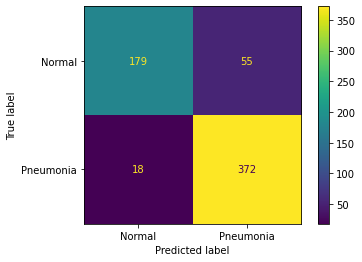

In [57]:
conf_mat(cnn4_model)

>

In [68]:
cnn5_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation=layers.LeakyReLU(), input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation=layers.LeakyReLU()),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation=layers.LeakyReLU()),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation=layers.LeakyReLU()),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

cnn5_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])

cnn5_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 64)      

In [69]:
cnn5_history = cnn5_model.fit(train_set_aug,
                    epochs=30,
                    batch_size=32,
                    validation_data=validation_set)

Epoch 1/30
131/131 [==============================] - 35s 266ms/step - loss: 0.5768 - accuracy: 0.7429 - recall: 0.9939 - auc: 0.5568 - prc: 0.7801 - val_loss: 0.5682 - val_accuracy: 0.7411 - val_recall: 0.9755 - val_auc: 0.7136 - val_prc: 0.8901
Epoch 2/30
131/131 [==============================] - 35s 270ms/step - loss: 0.5076 - accuracy: 0.7496 - recall: 0.9284 - auc: 0.7295 - prc: 0.8810 - val_loss: 0.4920 - val_accuracy: 0.7459 - val_recall: 0.9432 - val_auc: 0.7499 - val_prc: 0.9098
Epoch 3/30
131/131 [==============================] - 35s 267ms/step - loss: 0.4222 - accuracy: 0.7858 - recall: 0.9184 - auc: 0.8344 - prc: 0.9345 - val_loss: 0.5468 - val_accuracy: 0.7258 - val_recall: 0.6323 - val_auc: 0.9429 - val_prc: 0.9815
Epoch 4/30
131/131 [==============================] - 35s 268ms/step - loss: 0.3928 - accuracy: 0.8095 - recall: 0.8987 - auc: 0.8620 - prc: 0.9455 - val_loss: 0.3837 - val_accuracy: 0.8236 - val_recall: 0.7871 - val_auc: 0.9264 - val_prc: 0.9752
Epoch 5/30
1

In [70]:
cnn5_model.evaluate(test_set)

20/20 [==============================] - 3s 130ms/step - loss: 0.2837 - accuracy: 0.8926 - recall: 0.9256 - auc: 0.9520 - prc: 0.9704


[0.28370267152786255,
 0.8926281929016113,
 0.9256410002708435,
 0.9519559144973755,
 0.9704124927520752]

In [ ]:
conf_mat(cnn4_model)

>

# <a id="Visualizations">Visualizations</a>

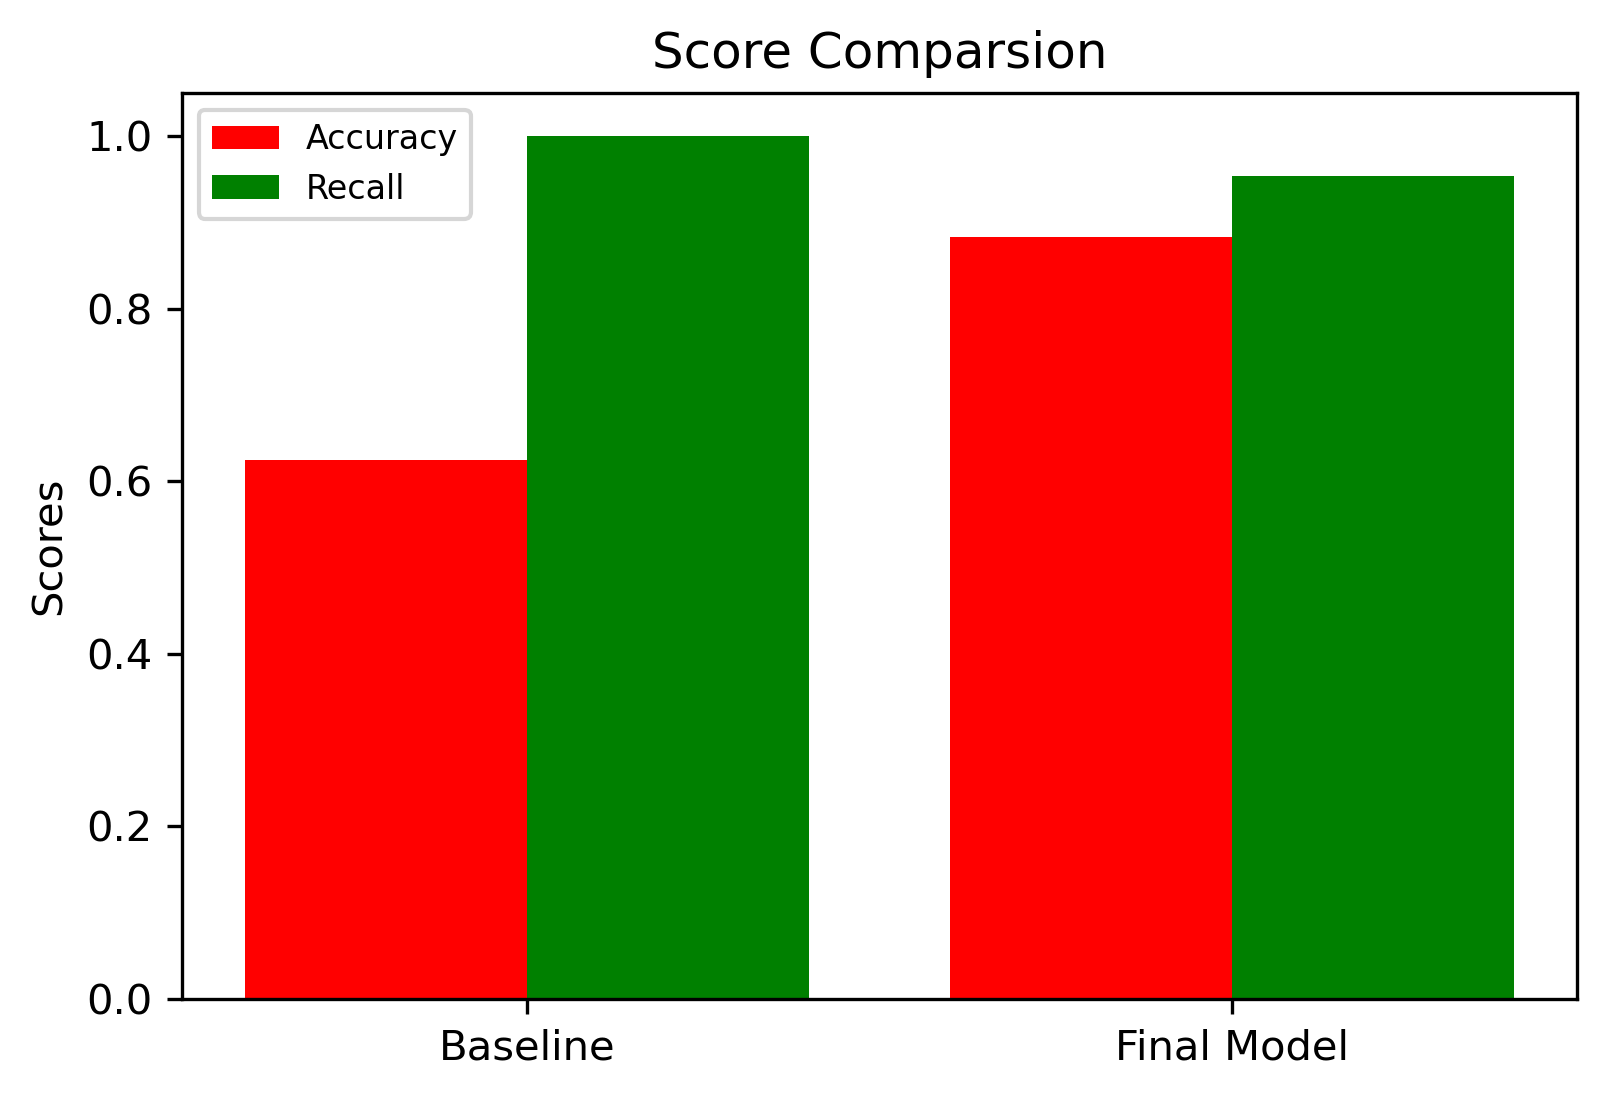

In [71]:
x = np.arange(2)
acc_scores = [0.625, 0.883]
prec_scores = [1.0, 0.954]
width = 0.4

fig, ax = plt.subplots(dpi=300)
plt.bar(x - 0.2, acc_scores, width, color='r')
plt.bar(x + 0.2, prec_scores, width, color='g')
plt.xticks(x, ['Baseline', 'Final Model'])
plt.ylabel('Scores')
plt.title('Score Comparsion')
ax.legend(['Accuracy', 'Recall'], fontsize=8)
plt.savefig('Images/Comparison.png');

# <a id="Conclusion">Conclusion</a>

# <a id="Next Steps">Next Steps</a>